In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

import seaborn as sns

import scanpy as sc
import palantir
from fa2 import ForceAtlas2
from sklearn.neighbors import NearestNeighbors
%matplotlib inline


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
from scipy.stats import gaussian_kde
def binary_plot(tsne,cat,cat_order,s=5,colored=False, vmax = None, vmin = None):
    tsne = np.array(tsne)
                      
    n = len(set(cat)); max_cols = 3
    nrows = int(np.ceil(n / max_cols)); ncols = int(min((max_cols, n)))
    fig = plt.figure(figsize=[5.5 * ncols, 4*nrows])
    
    if colored:
        for i,item in enumerate(list(set(cat))):
            colors = (cat == item) * 1
            order = np.argsort(np.array(colors))
            tmp = np.array(['lavender','black'])
            ax = fig.add_subplot(nrows, ncols, i+1)
            ax.scatter(np.array(tsne[:,0])[order], np.array(tsne[:,1])[order],s=s,c=tmp[np.array(colors * 1)][order])
            ax.set_title(item)
            ax.set_axis_off()   
                      
    else:
        for i,item in enumerate(cat_order):
            colors = (cat == item) * 1
            order = np.argsort(np.array(colors))
            tmp = np.array(['lavender','black'])
            ax = fig.add_subplot(nrows, ncols, i+1)
            xy = np.vstack([np.array(tsne[:,0])[cat == item], np.array(tsne[:,1])[cat == item]])
            z = gaussian_kde(xy)(xy)
            
            im = ax.scatter(np.array(tsne[:,0])[order], np.array(tsne[:,1])[order],s=s,c=tmp[np.array(colors * 1)][order])
            im = ax.scatter(np.array(tsne[:,0])[cat == item], np.array(tsne[:,1])[cat == item],s=s,c=z,cmap = 'viridis',
                           vmax = vmax, vmin = vmin)
            ax.set_title(item, fontsize = 18)
            fig.colorbar(im,ax=ax)
            ax.set_axis_off()
def plot_pca_genes(sc, count_matrix, samples, prcomp_data, colors):
    plt.rcParams['figure.figsize'] = [15,15]
    # f, axarr = plt.subplots(3, len(colors))
    fig = FigureGrid(3,3, scale=5)
    for g, ax in enumerate(fig):
        ax.scatter(prcomp_data[g*2],prcomp_data[g*2+1], alpha= 0.9, s=5, c = np.ravel(count_matrix.sum(axis=1)), cmap=plt.cm.Spectral_r)
#         ax.set_axis_off()
        ax.set_title(g)
    ax.yaxis.set_label_text('Library Size')
    fig = FigureGrid(3,3, scale=5)
    for g, ax in enumerate(fig):
        ax.scatter(prcomp_data[g*2],prcomp_data[g*2 + 1], alpha= 0.9, s=5, c = np.ravel(count_matrix.astype(bool).sum(axis=1)))
        ax.set_axis_off()
        ax.set_title(g)
    ax.yaxis.set_label_text('Unique number of genes')
def GetCellTypeFraction(clusters_rls, cell_type, order=None):
    proportions = pd.DataFrame(index=set(clusters_rls), columns=sorted(list(set(cell_type))))
    for cluster in set(clusters_rls):
        cells = cell_type.index[clusters_rls == cluster]
        for sample in sorted(list(set(cell_type))):
            sample_cells = cell_type.index[cell_type == sample]
            proportions.loc[cluster, sample] = len(cells.intersection(sample_cells)) / len(cells) * 100
    if order != None:
        proportions = proportions.loc[order]
    return proportions

In [3]:
sample2id = {
    'Sample_disso_D_cDNA_IGO_06000' : 'RA362',
    'Sample_RA407_IGO_12281_B_5': 'RA407',
    'Sample_RA395_IGO_12281_B_4': 'RA395',
    'Sample_RA385_IGO_12281_B_3': 'RA385',
    '363D_IGO_12281': 'RA363',
    'Sample_nml_IGO_12281_B_1': 'normal'
}


In [4]:
cluster_colors_long = np.array(["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",])

In [5]:
state_cmap = {
    'Inflamed Lining':'tab:orange', 
    'Inflamed Sublining':'tab:red',
    'Intermediate Inflamed/Resting Lining': 'gold', 
    'Intermediate Lining/Sublining':'tab:grey',
    'Resting Lining': 'tab:blue',
    'Resting Sublining':'tab:purple'
}

# Load Data

In [6]:
mdata = sc.read('/data/leslie/gaov/project/synfib_revision/data/forPub/adata_scatac_chromVAR_motif.h5')
adata = sc.read('/data/leslie/gaov/project/synfib_revision/data/forPub/adata_scrna_batchCorrected.h5')
mdata_combined = sc.read('/data/leslie/gaov/project/synfib_revision/data/forPub/adata_scatac_chromVAR_motif_cultured.h5')
adata.obs.index = [sample2id[x] + '#' + y for x,y in zip(adata.obs['sample'].values, adata.obs['barcodes'].values)]


In [7]:
shared_bc = list(set(adata.obs.index).intersection(set(mdata.obs.index)))
mdata = mdata[shared_bc]
adata = adata[shared_bc]

# Pre batch correction using Harmony

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


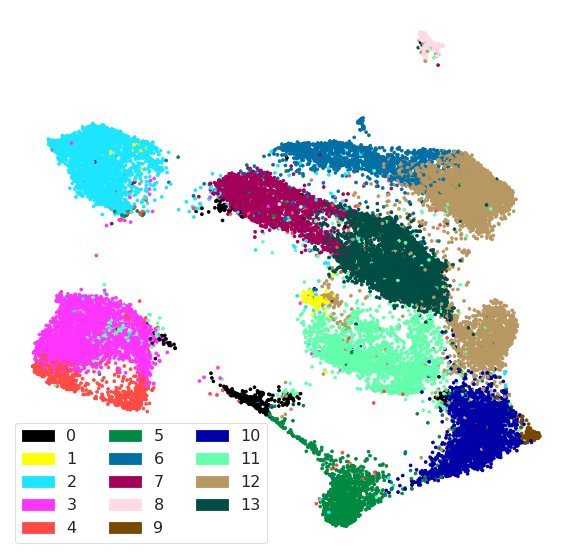

In [24]:
# Visualize Phenograph Clustering
embedding = mdata.obsm['X_atac_umap_noharmony'].values
a = np.array(list(map(int,list(mdata.obs['cluster_atac_noharmony'].values))))
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(embedding[:, 0], embedding[:, 1], 
           c=[cluster_colors_long[x] for x in a], s=8)
ax.set_axis_off()
handles = []
for i in set(a):
    handles.append(mpatches.Patch(label=i, color=cluster_colors_long[i]))
plt.legend(handles=handles, ncol=3, fontsize = 16)



findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


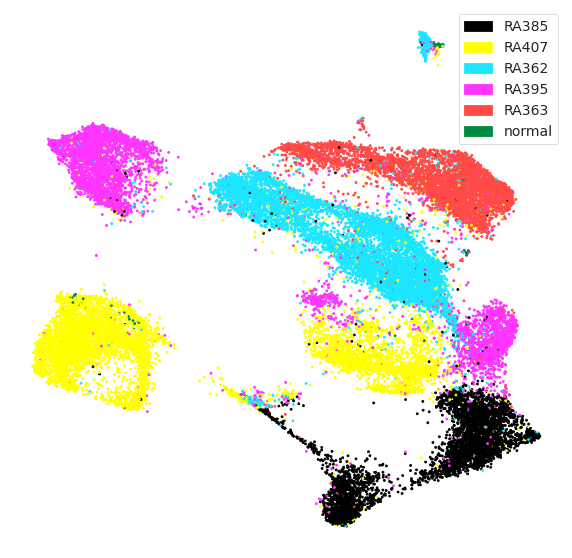

In [25]:
# Visualize samples
embedding = mdata.obsm['X_atac_umap_noharmony'].values
a = mdata.obs['Sample'].values
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(embedding[:, 0], embedding[:, 1], 
           c=[cluster_colors_long[x] for x in pd.factorize(a)[0]], s=4)
ax.set_axis_off()
handles = []
for j,i in enumerate(pd.factorize(a)[1]):
    handles.append(mpatches.Patch(label=i, color=cluster_colors_long[j]))
plt.legend(handles=handles, ncol=1, fontsize = 14)



findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


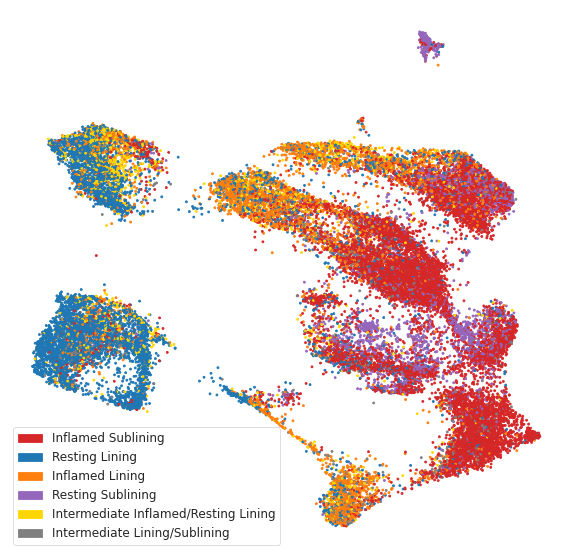

In [27]:
# Visualize fibroblast subtypes
embedding = mdata.obsm['X_atac_umap_noharmony'].values
a = mdata.obs['subtype_fine'].values
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(embedding[:, 0], embedding[:, 1], 
           c=[state_cmap[x] for x in a], s=4)
ax.set_axis_off()

handles = []
for j,i in enumerate(pd.factorize(a)[1]):

    handles.append(mpatches.Patch(label=i, color=state_cmap[i]))


plt.legend(handles=handles, ncol=1, fontsize = 12)



# Post batch correction using Harmony

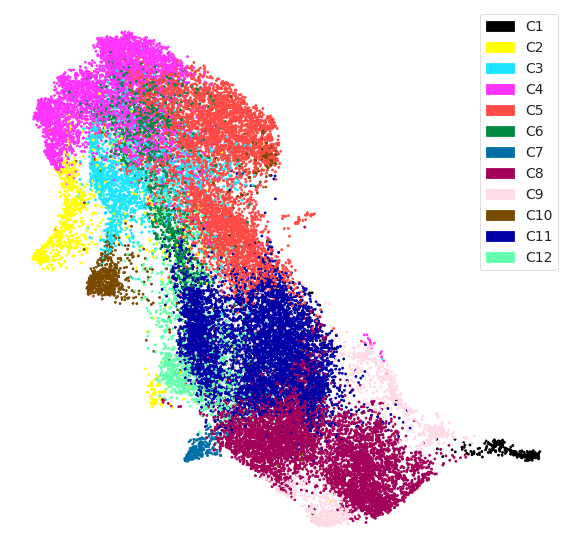

In [28]:
# Visualize Phenograph Clustering
embedding = mdata.obsm['X_atac_umap'].values
a = mdata.obs['Clusters'].values
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(embedding[:, 0], embedding[:, 1], 
           c=[cluster_colors_long[int(x.replace('C',''))-1] for x in a], s=4)
ax.set_axis_off()

handles = []
for j,i in enumerate(['C{}'.format(i) for i in range(1, 13)]):

    handles.append(mpatches.Patch(label=i, color=cluster_colors_long[int(i.replace('C',''))-1]))

plt.legend(handles=handles, ncol=1, fontsize = 14)



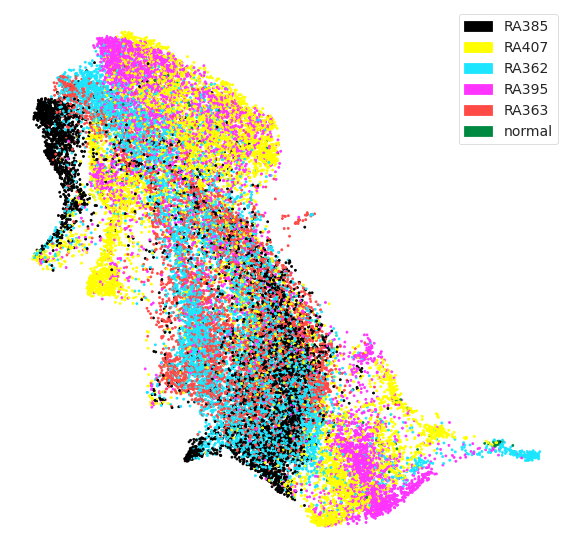

In [29]:
# Visualize samples
embedding = mdata.obsm['X_atac_umap'].values
a = mdata.obs['Sample'].values
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(embedding[:, 0], embedding[:, 1], 
           c=[cluster_colors_long[x] for x in pd.factorize(a)[0]], s=4)
ax.set_axis_off()
handles = []
for j,i in enumerate(pd.factorize(a)[1]):
    handles.append(mpatches.Patch(label=i, color=cluster_colors_long[j]))
plt.legend(handles=handles, ncol=1, fontsize = 14)



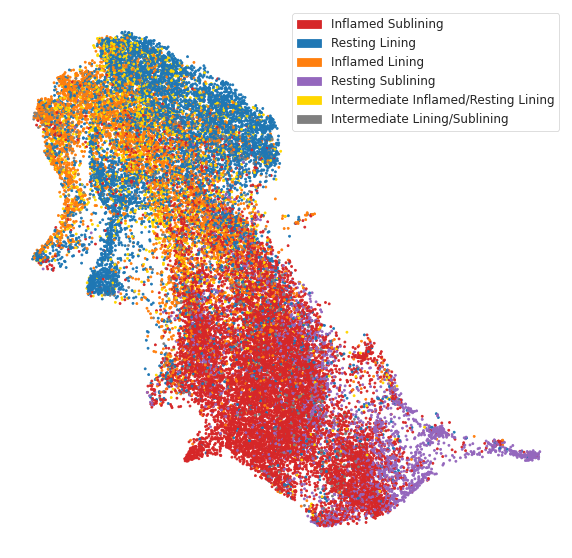

In [30]:
# Visualize fibroblast subtype
embedding = mdata.obsm['X_atac_umap'].values
a = mdata.obs['subtype_fine'].values
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(embedding[:, 0], embedding[:, 1], 
           c=[state_cmap[x] for x in a], s=4)
ax.set_axis_off()
handles = []
for j,i in enumerate(pd.factorize(a)[1]):
    handles.append(mpatches.Patch(label=i, color=state_cmap[i]))
plt.legend(handles=handles, ncol=1, fontsize = 12)



findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


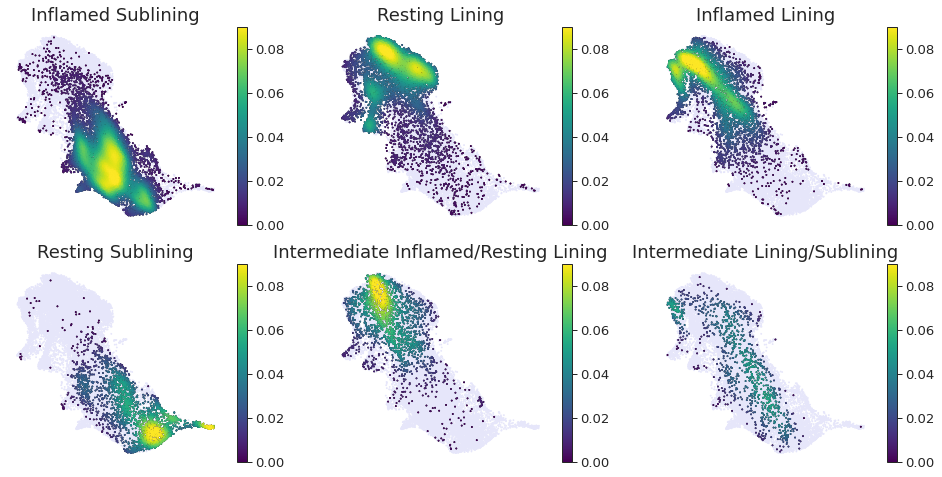

In [35]:
# Visualize fibroblast subtype
binary_plot(mdata.obsm['X_atac_umap'],mdata.obs['subtype_fine'].values, 
            cat_order=mdata.obs['subtype_fine'].value_counts().index, s = 1, vmax = 0.09, vmin = 0
           )


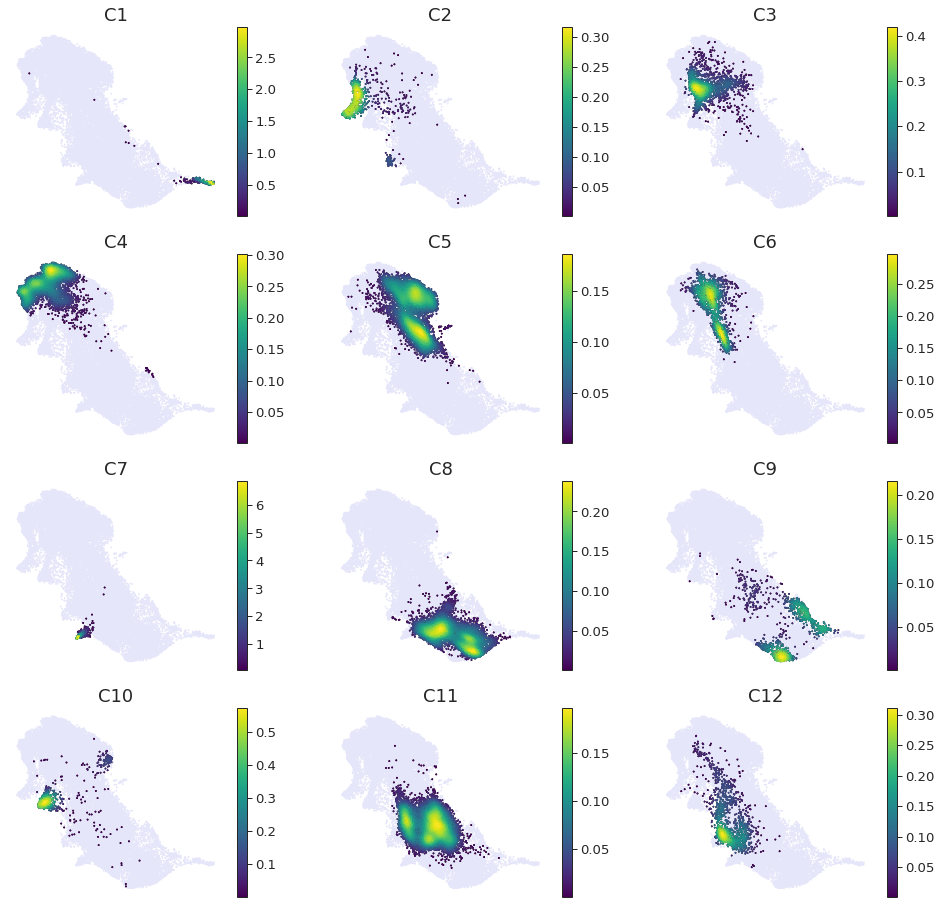

In [36]:
binary_plot(mdata.obsm['X_atac_umap'],mdata.obs['Clusters'].values, 
            cat_order=['C{}'.format(c) for c in range(1,13)], s = 1, 
           )


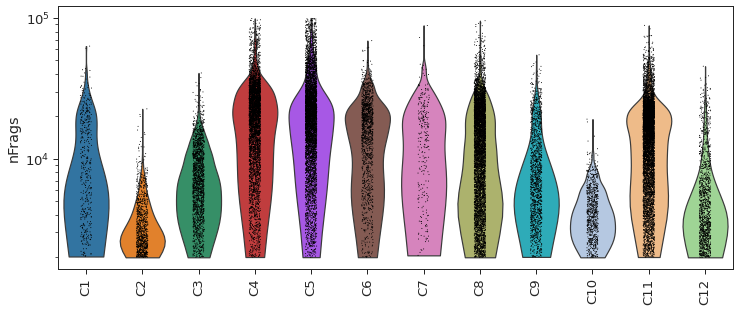

In [37]:
plt.rcParams['figure.figsize'] = [10,5]
t1 = sc.pl.violin(mdata, 'nFrags', groupby='Clusters', size=1, log=True, rotation=90)


Text(0.5, 1.0, 'Cluster Composition')

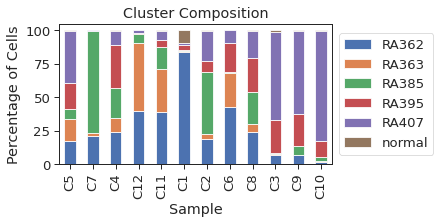

In [14]:
mdata.obs['Clusters'] = pd.Categorical(mdata.obs['Clusters'])

import matplotlib.colors as colors
proportions_samples = GetCellTypeFraction(np.array(list(mdata.obs['Clusters'].values)), mdata.obs['Sample'])
clust_major_rep = proportions_samples.columns[np.argmax(proportions_samples.values, axis=1)]
proportions_samples2 = proportions_samples.copy()
fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,3))

proportions_samples2.plot(kind='bar', stacked=True, ax=axes)
axes.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
axes.set_xlabel('Sample')
axes.set_ylabel('Percentage of Cells')
axes.set_title('Cluster Composition')


Text(0.5, 1.0, 'Cluster Composition')

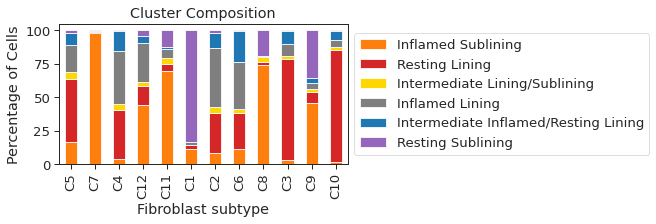

In [24]:
mdata.obs['Clusters'] = pd.Categorical(mdata.obs['Clusters'])

import matplotlib.colors as colors
proportions_samples = GetCellTypeFraction(np.array(list(mdata.obs['Clusters'].values)), mdata.obs['subtype_fine'])
clust_major_rep = proportions_samples.columns[np.argmax(proportions_samples.values, axis=1)]
proportions_samples2 = proportions_samples.copy()
fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(9,3))

proportions_samples2.iloc[:,[1,4,3,0,2,5]].plot(kind='bar', stacked=True, ax=axes, 
                          color = ['tab:orange', 'tab:red','gold', 'tab:grey','tab:blue','tab:purple'])
axes.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
axes.set_xlabel('Fibroblast subtype')
axes.set_ylabel('Percentage of Cells')
axes.set_title('Cluster Composition')


## Motif deviation

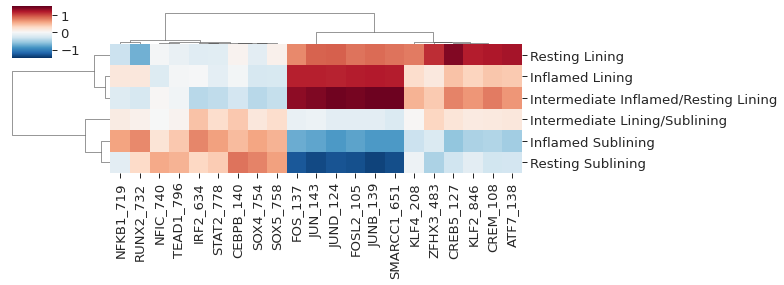

In [38]:
tmp = mdata
clust_mean = pd.DataFrame(np.array(tmp[:,list(['FOSL2_105', 'CREM_108', 'JUND_124', 'CREB5_127', 'FOS_137', 'ATF7_138',
       'JUNB_139', 'CEBPB_140', 'JUN_143', 'KLF4_208', 'ZFHX3_483', 'IRF2_634',
       'SMARCC1_651', 'NFKB1_719', 'RUNX2_732', 'NFIC_740', 'SOX4_754',
       'SOX5_758', 'STAT2_778', 'TEAD1_796' , 'KLF2_846',
       ])].X),columns=list(['FOSL2_105', 'CREM_108', 'JUND_124', 'CREB5_127', 'FOS_137', 'ATF7_138',
       'JUNB_139', 'CEBPB_140', 'JUN_143', 'KLF4_208', 'ZFHX3_483', 'IRF2_634',
       'SMARCC1_651', 'NFKB1_719', 'RUNX2_732', 'NFIC_740', 'SOX4_754',
       'SOX5_758', 'STAT2_778', 'TEAD1_796' , 'KLF2_846',
       ])).groupby(tmp.obs.subtype_fine.values).mean()

g=sns.clustermap(clust_mean, 
               cmap = 'RdBu_r', vmax = 1.5, vmin = -1.5, 
               figsize=(11,4), metric='sqeuclidean', #row_cluster=False
              )


[None, None, None, None, None, None]

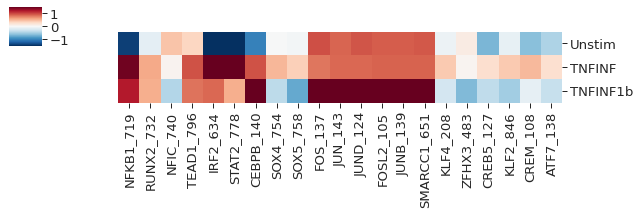

In [39]:
%matplotlib inline
tmp = mdata_combined
clust_mean = pd.DataFrame(np.array(tmp[:,list(['NFKB1_719',
 'RUNX2_732',
 'NFIC_740',
 'TEAD1_796',
 'IRF2_634',
 'STAT2_778',
 'CEBPB_140',
 'SOX4_754',
 'SOX5_758',
 'FOS_137',
 'JUN_143',
 'JUND_124',
 'FOSL2_105',
 'JUNB_139',
 'SMARCC1_651',
 'KLF4_208',
 'ZFHX3_483',
 'CREB5_127',
 'KLF2_846',
 'CREM_108',
 'ATF7_138']
)].X),columns=list(['NFKB1_719',
 'RUNX2_732',
 'NFIC_740',
 'TEAD1_796',
 'IRF2_634',
 'STAT2_778',
 'CEBPB_140',
 'SOX4_754',
 'SOX5_758',
 'FOS_137',
 'JUN_143',
 'JUND_124',
 'FOSL2_105',
 'JUNB_139',
 'SMARCC1_651',
 'KLF4_208',
 'ZFHX3_483',
 'CREB5_127',
 'KLF2_846',
 'CREM_108',
 'ATF7_138']
)).groupby(tmp.obs.condition.values).mean()

g=sns.clustermap(clust_mean.loc[['Unstim','TNFINF','TNFINF1b']], 
               cmap = 'RdBu_r', vmax = 1.5, vmin = -1.5, 
               figsize=(9,3), metric='sqeuclidean', row_cluster=False, 
                 col_cluster = False
              )
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)



## Motif differential accessibility

In [20]:
sc.tl.rank_genes_groups(mdata, groupby='subtype_fine',method='wilcoxon', key_added='motif_enrichment_by_subtype')
sc.tl.rank_genes_groups(mdata, groupby='cluster_harmony_k100',method='wilcoxon')

/lila/data/leslie/gaov/tools/scanpy/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


In [21]:
tf_genes = [x.split('_')[0] for x in mdata.var.index]

In [22]:
tf_expression = pd.DataFrame(adata[mdata.obs.index,list(set(tf_genes).intersection(adata.var.index))].layers['count'], columns = adata[:,list(set(tf_genes).intersection(adata.var.index))].var.index)


In [23]:
cor_df = np.corrcoef(np.concatenate([tf_expression.values.T,mdata.X.T]))

/home/gaov/anaconda3/envs/scanpy/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/gaov/anaconda3/envs/scanpy/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [24]:
cor_df = cor_df[0:780, 780:]

In [25]:
cor_df = pd.DataFrame(cor_df, index = tf_expression.columns, columns=list(mdata.var.index))

In [26]:
cor_df = cor_df.fillna(0)

In [27]:
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = [8,7]


In [28]:
def ranked_genes_to_df(rank_gene_group):
    deg_names = pd.DataFrame(rank_gene_group['names'])
    deg_pval = pd.DataFrame(rank_gene_group['pvals'])
    deg_qval = pd.DataFrame(rank_gene_group['pvals_adj'])
    deg_lfc = pd.DataFrame(rank_gene_group['logfoldchanges'])
    deg_score = pd.DataFrame(rank_gene_group['scores'])
    df = {}
    for i in sorted(list(set(rank_gene_group['names'].dtype.names))):
        df[i] = pd.concat([deg_names[i],deg_pval[i],deg_qval[i],deg_lfc[i],deg_score[i]], axis=1,
         keys=['gene','pval','qval','log2fc','score'])
    return df


### Motif deviation across fibroblast states

In [29]:
motif_list = []

In [30]:
rank_gene_dict = ranked_genes_to_df(mdata.uns['motif_enrichment_by_subtype'])

In [31]:
for g in rank_gene_dict.keys():
    tfs = rank_gene_dict[g]['gene']
    tfs_gene = [tf.split('_')[0] for tf in tfs]
    tfs_gene_pass_1 = [t in adata.var.index for t in tfs_gene]
    tfs_gene_pass_1 = np.array(tfs_gene)[tfs_gene_pass_1]
    tf_exp = tf_expression[tfs_gene_pass_1].loc[mdata.obs['subtype_fine'].values==g]
    tfs_gene_pass_2 = tfs_gene_pass_1[(tf_exp>0).sum(0) > sum(mdata.obs['subtype_fine']==g)*0.2]
    tfs_gene_pass_2 = [t in tfs_gene_pass_2 for t in tfs_gene]
    rank_gene_dict[g] = rank_gene_dict[g][tfs_gene_pass_2]
    
    

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


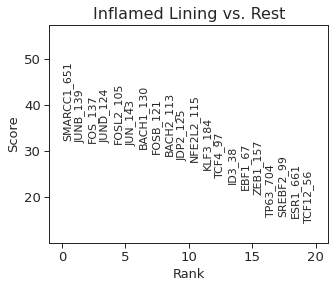

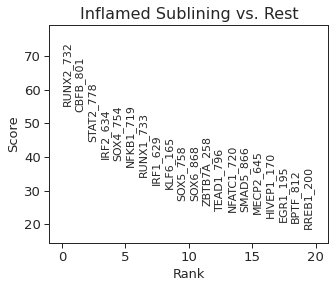

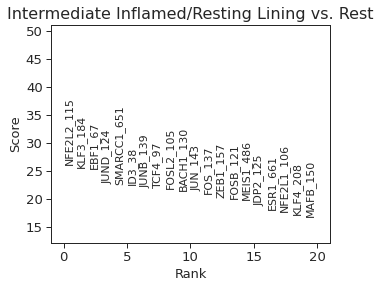

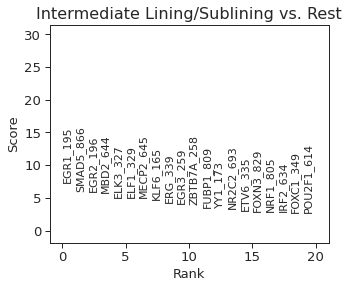

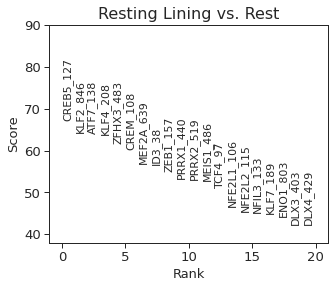

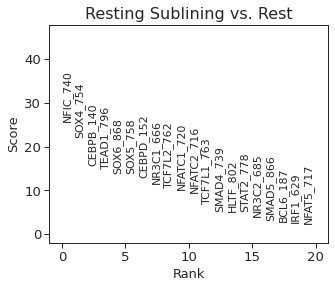

In [60]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = [5,4]
for g in rank_gene_dict.keys():
    plt.plot(rank_gene_dict[g]['score'].values[0:20], marker = '.', linestyle = '', color = 'white')
    for i in range(20):
        plt.annotate(rank_gene_dict[g]['gene'].values[i],
                     (i, rank_gene_dict[g]['score'].values[i]),
                    rotation = 90, fontsize = 11)
    plt.ylim(rank_gene_dict[g]['score'].values[19] - 5,rank_gene_dict[g]['score'].values[1] + 25)
    plt.xlim(-1,21)
    plt.ylabel('Score', fontsize = 13)
    plt.xlabel('Rank', fontsize = 13)
    plt.title('{} vs. Rest'.format(g), fontsize = 16)
    plt.show()


### Motif deviation across RNA-seq clusters

In [33]:
rank_gene_dict = ranked_genes_to_df(mdata.uns['rank_genes_groups'])

In [34]:
for g in rank_gene_dict.keys():
    tfs = rank_gene_dict[g]['gene']
    tfs_gene = [tf.split('_')[0] for tf in tfs]
    tfs_gene_pass_1 = [t in adata.var.index for t in tfs_gene]
    tfs_gene_pass_1 = np.array(tfs_gene)[tfs_gene_pass_1]
    tf_exp = tf_expression[tfs_gene_pass_1].loc[mdata.obs['cluster_harmony_k100'].values==int(g)]
    tfs_gene_pass_2 = tfs_gene_pass_1[(tf_exp>0).sum(0) > sum(mdata.obs['cluster_harmony_k100']==int(g))*0.2]
    tfs_gene_pass_2 = [t in tfs_gene_pass_2 for t in tfs_gene]
    rank_gene_dict[g] = rank_gene_dict[g][tfs_gene_pass_2]
    
    

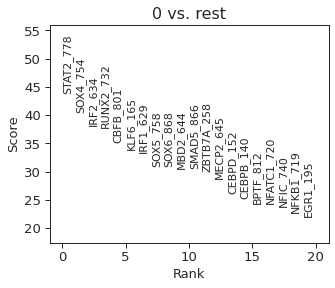

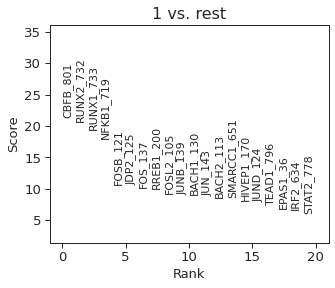

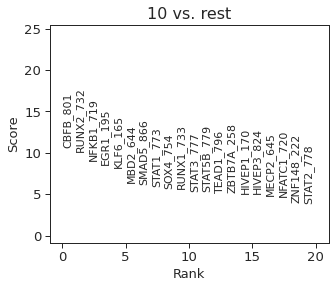

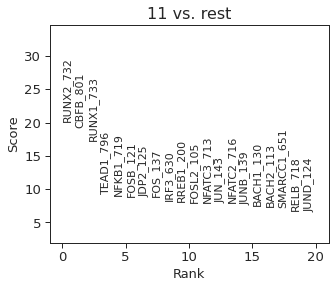

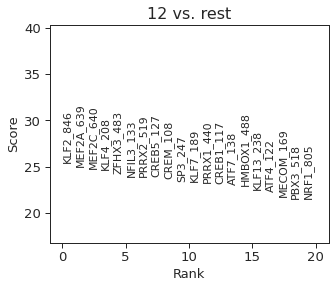

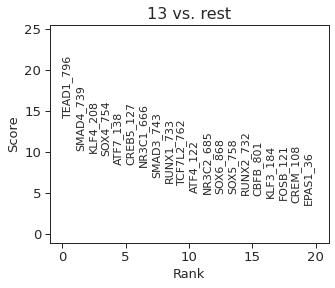

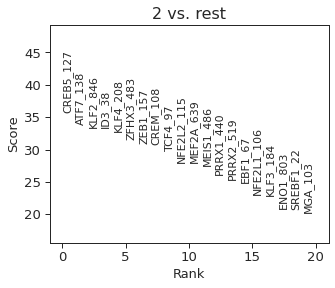

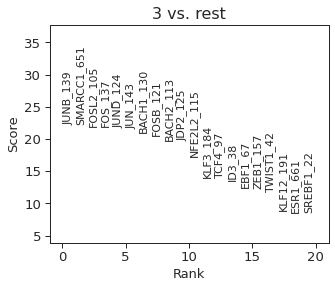

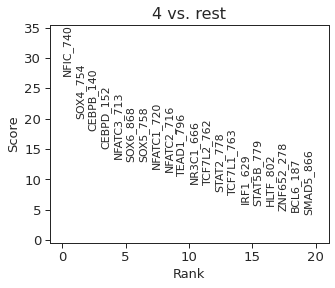

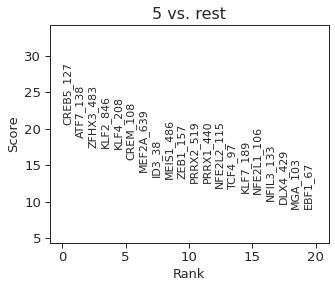

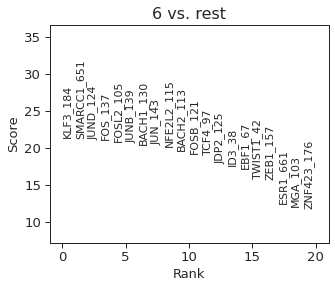

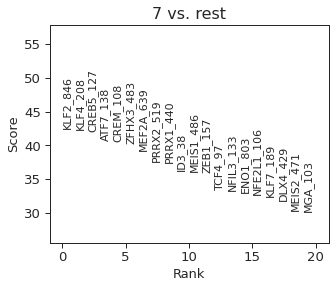

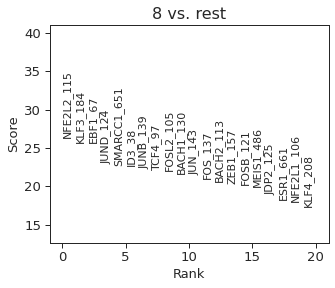

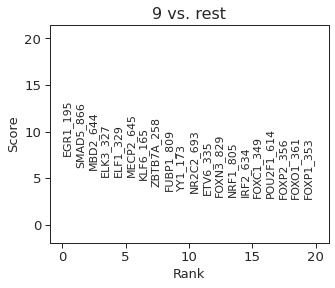

In [78]:
for g in rank_gene_dict.keys():
    plt.plot(rank_gene_dict[g]['score'].values[0:20], marker = '.', linestyle = '', color = 'white')
    for i in range(20):
        plt.annotate(rank_gene_dict[g]['gene'].values[i],
                     (i, rank_gene_dict[g]['score'].values[i]),
                    rotation = 90, fontsize = 11)
    plt.ylim(rank_gene_dict[g]['score'].values[19] - 5, rank_gene_dict[g]['score'].values[1] + 15)
    plt.xlim(-1,21)
    plt.ylabel('Score', fontsize = 13)
    plt.xlabel('Rank', fontsize = 13)
    plt.title('{} vs. rest'.format(g), fontsize = 16)
    plt.show()


## Compare motif activity across all conditions (cultured + dissociated)

In [79]:
mdata = sc.read('/data/leslie/gaov/project/synfib_revision/data/forPub/adata_scatac_chromVAR_motif_all_samples.h5')

In [80]:
motif_names = ['STAT1_773', 'STAT2_778', 'STAT3_777', 'STAT5B_779','IRF9_636']
df = pd.DataFrame(mdata[:,motif_names].X, columns = motif_names)
df['subtype_fine'] = mdata.obs['subtype'].values


/home/gaov/anaconda3/envs/scanpy/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


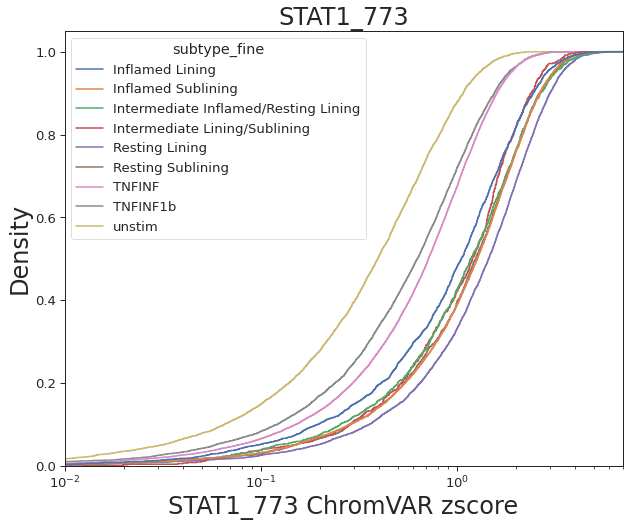

In [81]:
plt.rcParams['figure.figsize'] = [10,8]
motif_name = 'STAT1_773'
ax = sns.histplot(
    data=df, x=motif_name, hue="subtype_fine", bins = 2000,
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,legend=True, linewidth=1.5
)
plt.xlim(10e-3,7)
plt.xlabel('{} ChromVAR zscore'.format(motif_name))
plt.title(motif_name)
ax.grid(False)


# ChromVAR motif deviation

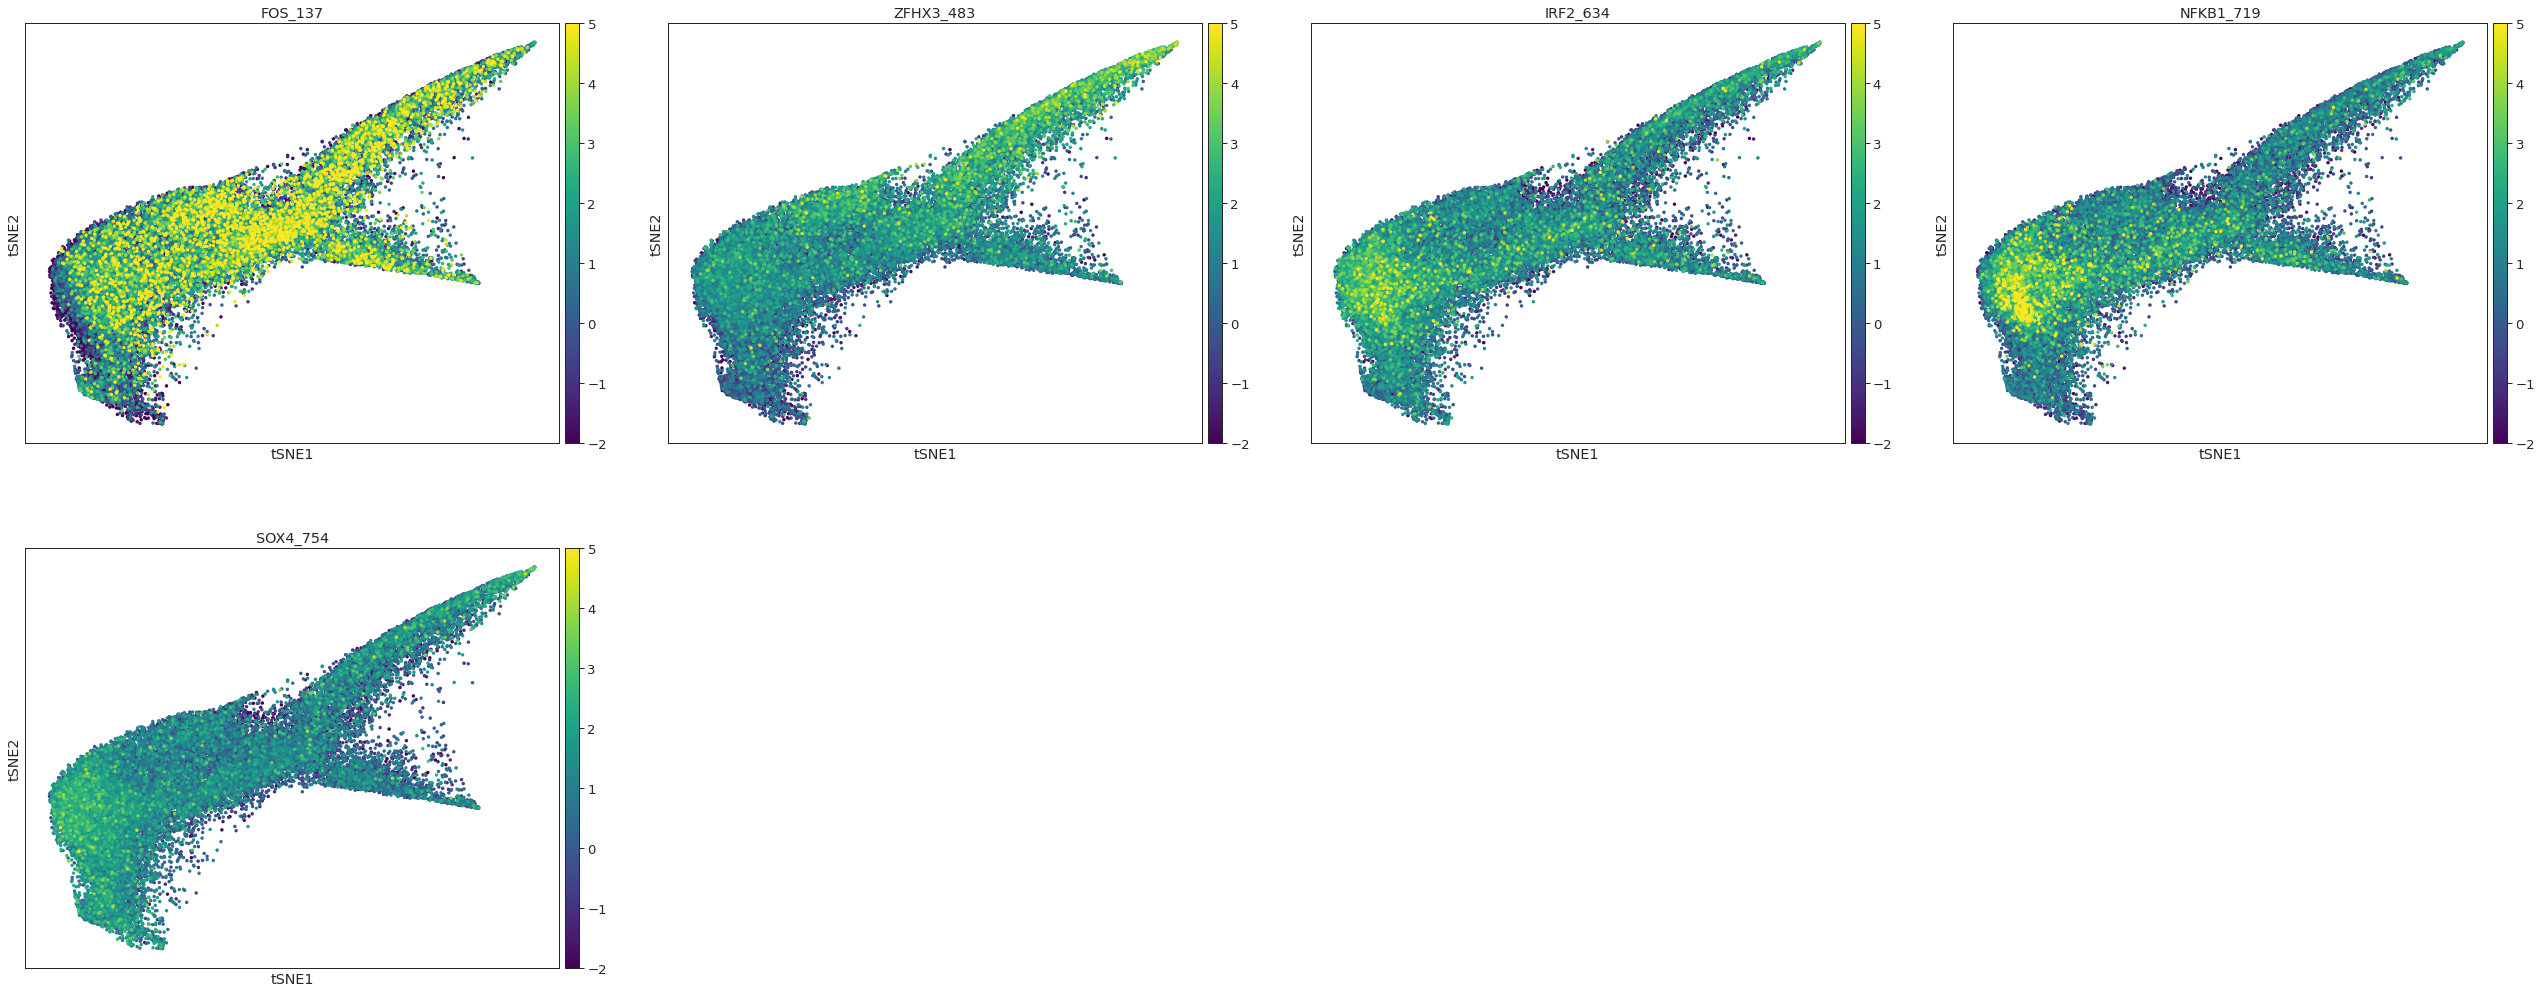

In [17]:
mdata.obsm['X_tsne'] = adata[mdata.obs.index].obsm['X_fd']
sc.pl.tsne(mdata, color = ['FOS_137', 'ZFHX3_483', 'IRF2_634',
       'NFKB1_719', 'SOX4_754'],
           vmax = 5,
           vmin = -2, 
           cmap = 'viridis', s = 48,
      )

